<a href="https://colab.research.google.com/github/hrnnikolov/ML_models/blob/main/model_deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Getting Data



In [1]:
# # For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
# try:
#     import torch
#     import torchvision
#     assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
#     assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
#     print(f"torch version: {torch.__version__}")
#     print(f"torchvision version: {torchvision.__version__}")
# except:
#     print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
#     !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
#     import torch
#     import torchvision
#     print(f"torch version: {torch.__version__}")
#     print(f"torchvision version: {torchvision.__version__}")

In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 35.75 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [5]:
train_dir = data_20_percent_path / 'train'
test_dir = data_20_percent_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

#Creating Effnetb2 model

In [6]:
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

effnetb2_transforms = effnetb2_weights.transforms()

effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

for param in effnetb2.parameters():
  param.requires_grad = False

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 95.3MB/s]


In [7]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [8]:
effnetb2.classifier = nn.Sequential(nn.Dropout(p=0.3, inplace=True),
                                    nn.Linear(in_features=1408,
                                              out_features=3))

In [9]:
def create_effnetb2_model(num_classes:int=3,
                          seed:int=33):

  effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

  transforms = effnetb2_weights.transforms()

  model = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)

  model.classifier = nn.Sequential(nn.Dropout(p=0.3, inplace=True),
                                    nn.Linear(in_features=1408,
                                              out_features=num_classes))

  return model, transforms

In [10]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=33)

effnetb2, effnetb2_transforms

(EfficientNet(
   (features): Sequential(
     (0): Conv2dNormActivation(
       (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): SiLU(inplace=True)
     )
     (1): Sequential(
       (0): MBConv(
         (block): Sequential(
           (0): Conv2dNormActivation(
             (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
             (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
             (2): SiLU(inplace=True)
           )
           (1): SqueezeExcitation(
             (avgpool): AdaptiveAvgPool2d(output_size=1)
             (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
             (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
             (activation): SiLU(inplace=True)
             (scale_activation): Sigmoid()
           )
          

# Creating DataLoaders

In [11]:
from going_modular.going_modular import data_setup
import torchvision

BATCH_SIZE=32

train_dataloader, test_dataloader , class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                test_dir=test_dir,
                                                                                transform=effnetb2_transforms,
                                                                                batch_size=BATCH_SIZE)

In [12]:
train_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7d149b037e20>,
 ['pizza', 'steak', 'sushi'])

In [13]:
from going_modular.going_modular import engine

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=0.001)

effnetb2_results = engine.train(model=effnetb2,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader,
             optimizer=optimizer,
             loss_fn=loss_fn,
             epochs=3,
             device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 0.9518 | train_acc: 0.5604 | test_loss: 0.7435 | test_acc: 0.8767
Epoch: 2 | train_loss: 0.7419 | train_acc: 0.7771 | test_loss: 0.5946 | test_acc: 0.9256
Epoch: 3 | train_loss: 0.5851 | train_acc: 0.8458 | test_loss: 0.5217 | test_acc: 0.9290


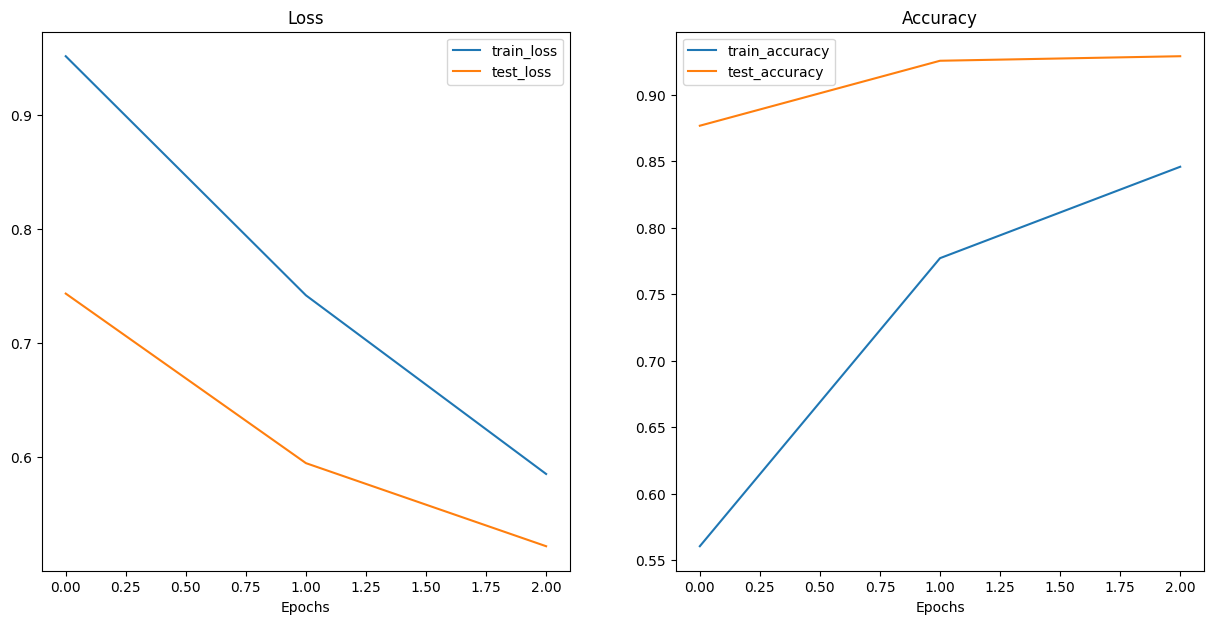

In [14]:
plot_loss_curves(effnetb2_results)

In [15]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


In [16]:
from pathlib import Path

pretrained_effnetb2_model_size = Path('models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth').stat().st_size / (1024 * 1024)
print(f'Your model size is {pretrained_effnetb2_model_size:.2f} mb')

Your model size is 29.86 mb


# effnetb2 stats

In [17]:
#num of params
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [18]:
# effnetb2 dic stats
effnetb2_stats = {'test_loss': effnetb2_results['test_loss'][-1],
                  'test_acc': effnetb2_results['test_acc'][-1],
                  'number_of_parameters': effnetb2_total_params,
                  'model_size (MB)': pretrained_effnetb2_model_size}

effnetb2_stats


{'test_loss': 0.5216582179069519,
 'test_acc': 0.9289772727272727,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.8638858795166}

# Creating ViT model

In [19]:
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [20]:
def create_vitb16_model(num_classes:int=3,
                        seed:int=33):
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights=weights)

  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)
  model.heads = nn.Sequential(nn.Linear(in_features=768,
                                         out_features=num_classes))

  return model, transforms

In [21]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):
    """Creates a ViT-B/16 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of target classes. Defaults to 3.
        seed (int, optional): random seed value for output layer. Defaults to 42.

    Returns:
        model (torch.nn.Module): ViT-B/16 feature extractor model.
        transforms (torchvision.transforms): ViT-B/16 image transforms.
    """
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                          out_features=num_classes)) # update to reflect target number of classes

    return model, transforms

In [22]:
# Create ViT model and transforms
vit, vit_transforms = create_vit_model(num_classes=3,
                                       seed=42)


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 146MB/s]


In [23]:
# Setup ViT DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

In [24]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train ViT model with seeds set for reproducibility
set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=3,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693


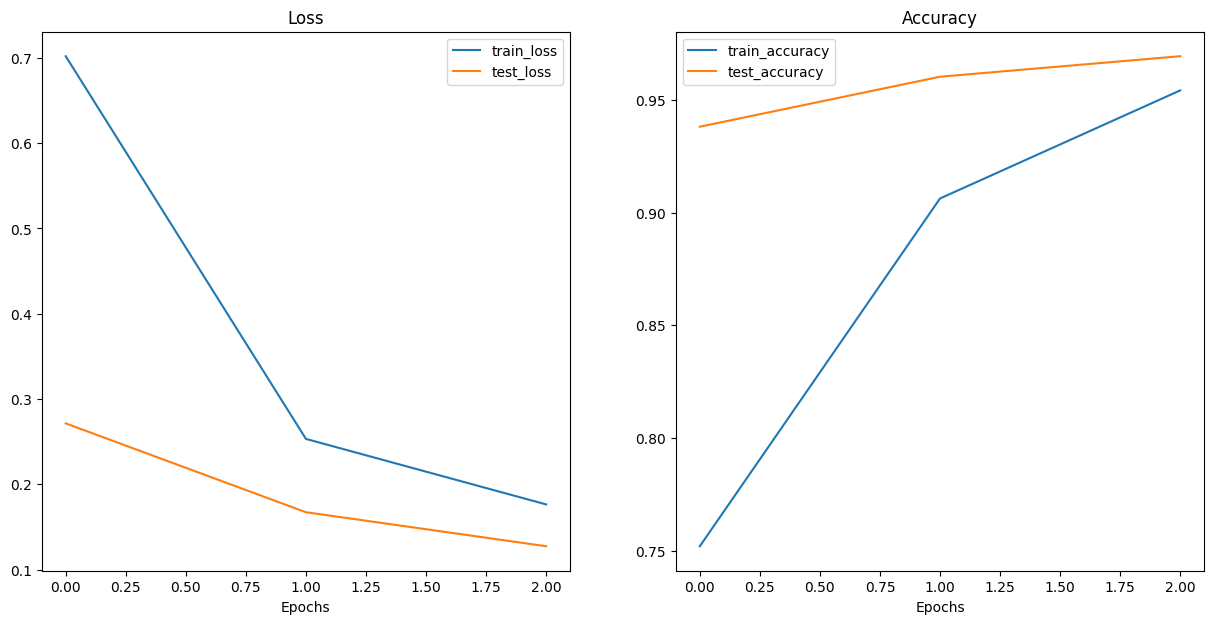

In [25]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

In [26]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vitb16_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_vitb16_feature_extractor_pizza_steak_sushi_20_percent.pth


In [27]:
from pathlib import Path

pretrained_vit_model_size = Path('models/09_pretrained_vitb16_feature_extractor_pizza_steak_sushi_20_percent.pth').stat().st_size / (1024 * 1024)
print(f'Your model size is {pretrained_vit_model_size:.2f} mb')

Your model size is 327.37 mb


In [28]:
#num of params
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [29]:
# effnetb2 dic stats
vit_stats = {'test_loss': vit_results['test_loss'][-1],
                  'test_acc': vit_results['test_acc'][-1],
                  'number_of_parameters': vit_total_params,
                  'model_size (MB)': pretrained_vit_model_size}

vit_stats

{'test_loss': 0.12734055388718843,
 'test_acc': 0.9693181818181819,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.3714771270752}

In [30]:
test_data_paths = list(Path(test_dir).glob('*/*.jpg'))
test_data_paths

[PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/1618659.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/380739.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/1315645.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3729167.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3497151.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2782998.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/419962.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/930553.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2549661.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/138961.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2398925.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/296426.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2572488.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/788315.jpg')

In [31]:
import pathlib
import torch
import torchvision

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict


def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = 'cuda' if torch.cuda.is_available() else 'cpu') ->List[Dict]:

  pred_list = []

  for path in tqdm(paths):
    pred_dict = {}
    pred_dict['image_path'] = path
    class_name = path.parent.stem
    pred_dict['class_name'] = class_name

    start_time = timer()
    img = Image.open(path)

    transformed_image = transform(img).unsqueeze(0).to(device)

    model = model.to(device)
    model.eval()

    with torch.inference_mode():
      pred_logit = model(transformed_image) # perform inference on target sample
      pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
      pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
      pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

      # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on)
      pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
      pred_dict["pred_class"] = pred_class

      end_time = timer()
      pred_dict['time_for_pred'] = round(end_time-start_time, 4)


    pred_dict['correct'] = class_name == pred_class

    pred_list.append(pred_dict)

  return pred_list


In [32]:
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device='cpu')

  0%|          | 0/150 [00:00<?, ?it/s]

In [33]:
effnetb2_test_pred_dicts

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/1618659.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.4671,
  'pred_class': 'pizza',
  'time_for_pred': 0.3097,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/380739.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.7449,
  'pred_class': 'pizza',
  'time_for_pred': 0.1264,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/1315645.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.5308,
  'pred_class': 'pizza',
  'time_for_pred': 0.1177,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3729167.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.7578,
  'pred_class': 'pizza',
  'time_for_pred': 0.1173,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3497151.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9068,
  'pred_class': 'pizza',
  'time_for_p

In [34]:
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.4671,pizza,0.3097,True
1,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.7449,pizza,0.1264,True
2,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.5308,pizza,0.1177,True
3,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.7578,pizza,0.1173,True
4,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9068,pizza,0.1284,True


In [35]:
# Find the average time per prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds")

EffNetB2 average time per prediction: 0.1186 seconds


In [36]:
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=vit,
                                          transform=vit_transforms,
                                          class_names=class_names,
                                          device='cpu')

  0%|          | 0/150 [00:00<?, ?it/s]

In [37]:
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.9879,pizza,0.7769,True
1,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9920,pizza,0.5874,True
2,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.9127,pizza,0.5816,True
3,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9923,pizza,0.7986,True
4,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9841,pizza,0.9547,True


In [38]:
# Find the average time per prediction
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred} seconds")

ViT average time per prediction: 0.6312 seconds


In [39]:
# Count the number of correct predictions
vit_test_pred_df.correct.value_counts()

correct
True     146
False      4
Name: count, dtype: int64

In [40]:
# Add average prediction time for ViT model on CPU
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.12734055388718843,
 'test_acc': 0.9693181818181819,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.3714771270752,
 'time_per_pred_cpu': 0.6312}

In [41]:
# Add EffNetB2 average prediction time to stats dictionary
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.5216582179069519,
 'test_acc': 0.9289772727272727,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.8638858795166,
 'time_per_pred_cpu': 0.1186}

In [42]:
df = pd.DataFrame([effnetb2_stats, vit_stats])

df['model'] = ['EffNetB2', 'ViT']

df['test_acc'] = round(df['test_acc'] * 100, 2)
df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.521658,92.90,7705221,29.863886,0.1186,EffNetB2
1,0.127341,96.93,85800963,327.371477,0.6312,ViT


In [43]:
pd.DataFrame(data=(df.set_index('model').loc['ViT'] / df.set_index('model').loc['EffNetB2']),
             columns=['ViT to EffNetB2 ratios']).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.244107,1.04338,11.135432,10.962119,5.322091


In [44]:
df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.521658,92.90,7705221,29.863886,0.1186,EffNetB2
1,0.127341,96.93,85800963,327.371477,0.6312,ViT


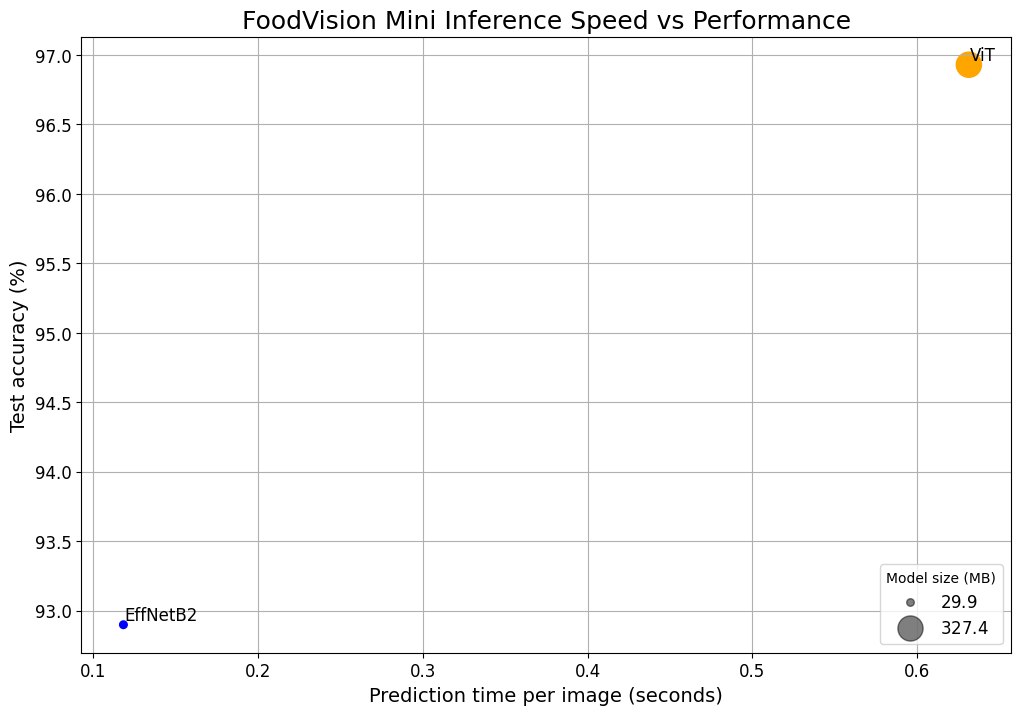

In [45]:
# 1. Create a plot from model comparison DataFrame
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"], # what colours to use?
                     s="model_size (MB)") # size the dots by the model sizes

# 2. Add titles, labels and customize fontsize for aesthetics
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid('True')

for index, row in df.iterrows():
  ax.annotate(text=row["model"], # note: depending on your version of Matplotlib, you may need to use "s=..." or "text=...", see: https://github.com/faustomorales/keras-ocr/issues/183#issuecomment-977733270
                xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
                size=12)

handles, labels = scatter.legend_elements(prop='sizes', alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc='lower right',
                              title='Model size (MB)',
                              fontsize=12)

# Save the figure
plt.savefig("09-foodvision-mini-inference-speed-vs-performance.jpg")

# Show the figure
plt.show()

# Creating a Gradio Demo

In [46]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 9.3 MB/s eta 0:00:00
Gradio version: 4.26.0


#Creating a function to map our inputs and outputs

In [47]:
effnetb2 = effnetb2.to('cpu')

next(iter(effnetb2.parameters())).device

device(type='cpu')

In [48]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:

  start_time = timer()

  #transform image
  img = effnetb2_transforms(img).unsqueeze(0)

  #put model in eval mode and make prediction
  effnetb2.eval()
  with torch.inference_mode():
    pred_probs = torch.softmax(effnetb2(img), dim=1)

  #create a pred label and pred probability dict
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  #calc pred time
  end_time = timer()
  pred_time = round(end_time - start_time, 4)
  return pred_labels_and_probs, pred_time

In [49]:
import random
from PIL import Image

#Get a list of all test image filepath
test_data_paths = list(Path(test_dir).glob('*/*.jpg'))

#randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

#open target image
image = Image.open(random_image_path)
print(f'[INFO] Predict on image at path {random_image_path}\n')

#Predict on random image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(pred_dict)
print(pred_time)

[INFO] Predict on image at path data/pizza_steak_sushi_20_percent/test/sushi/593071.jpg

{'pizza': 0.2631780207157135, 'steak': 0.1993040293455124, 'sushi': 0.5375179052352905}
0.1103


# Create a list of examples

In [50]:
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/steak/2307638.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/3063435.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/48208.jpg']]

#Build a Gradio Interface

In [51]:
import gradio as gr

title = 'FoodVision Mini 🍕🥩🍣'
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
#article = "Created at [09. PyTorch Model Deployment]"

demo = gr.Interface(inputs=gr.Image(type='pil'),
                    outputs=[gr.Label(num_top_classes=3, label='Predictions'),
                             gr.Number(label='Prediction time (s)')],
                    examples=example_list,
                    fn=predict,
                    title=title,
                    description=description)

demo.launch(debug=False,
            share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://2d0e26f9612071f53d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


# Turning Gradio Demot into a deployable app

In [52]:
import shutil
from pathlib import Path

#create demo path
foodvision_mini_demo_path = Path('demos/foodvision_mini/')

#remove files that might exist and create a new directory
if foodvision_mini_demo_path.exists():
  shutil.rmtree(foodvision_mini_demo_path)
  foodvision_mini_demo_path.mkdir(parents=True,
                                  exist_ok=True)
else:
  foodvision_mini_demo_path.mkdir(parents=True,
                                  exist_ok=True)

!ls demos/foodvision_mini/

In [53]:
import shutil
from pathlib import Path

#create an example direct
foodvision_mini_example_path = foodvision_mini_demo_path / 'examples'
foodvision_mini_example_path.mkdir(parents=True,
                                   exist_ok=True)

# 2. Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# copy the 3 images to the examples dir
for example in foodvision_mini_examples:
  destination = foodvision_mini_example_path / example.name
  print(f'[INFO] Copying {example} to {destination}')
  shutil.copy2(src=example,
               dst=destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/foodvision_mini/examples/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/foodvision_mini/examples/3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/foodvision_mini/examples/2582289.jpg


In [54]:
import os
example_list = [['examples/' + example] for example in os.listdir(foodvision_mini_example_path)]
example_list

[['examples/3622237.jpg'], ['examples/2582289.jpg'], ['examples/592799.jpg']]

In [55]:
# Moving the effnetb2 model

import shutil
#source
effnetb2_foodvision_mini_model_path = '/content/models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth'

#destination
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[-1]

# try to move the model file
try:
    print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")

    # Move the model
    shutil.move(src=effnetb2_foodvision_mini_model_path,
                dst=effnetb2_foodvision_mini_model_destination)

    print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")

[INFO] Attempting to move /content/models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth to demos/foodvision_mini/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] Model move complete.


# Turning effnetb2 model into a python script

In [56]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision
from torch import nn

def create_effnetb2_model(num_classes:int=3,
                          seed:int=33):

  effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

  transforms = effnetb2_weights.transforms()

  model = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)

  model.classifier = nn.Sequential(nn.Dropout(p=0.3, inplace=True),
                                    nn.Linear(in_features=1408,
                                              out_features=num_classes))

  return model, transforms

Writing demos/foodvision_mini/model.py


In [57]:
class_names

['pizza', 'steak', 'sushi']

In [58]:
%%writefile demos/foodvision_mini/app.py
# imports and class_names
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

class_names = ['pizza', 'steak', 'sushi']

# model and transforms
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes = len(class_names)
)


effnetb2.load_state_dict(
    torch.load(
        f'09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth',
        map_location=torch.device('cpu')
    )
)

# pred fn
def predict(img) -> Tuple[Dict, float]:

  start_time = timer()

  #transform image
  img = effnetb2_transforms(img).unsqueeze(0)

  #put model in eval mode and make prediction
  effnetb2.eval()
  with torch.inference_mode():
    pred_probs = torch.softmax(effnetb2(img), dim=1)

  #create a pred label and pred probability dict
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  #calc pred time
  end_time = timer()
  pred_time = round(end_time - start_time, 4)
  return pred_labels_and_probs, pred_time

#Gradio app

title = 'FoodVision Mini 🍕🥩🍣'
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."

#create example list
example_list = [['examples/' + example] for example in os.listdir('examples')]

demo = gr.Interface(inputs=gr.Image(type='pil'),
                    outputs=[gr.Label(num_top_classes=3, label='Predictions'),
                             gr.Number(label='Prediction time (s)')],
                    examples=example_list,
                    fn=predict,
                    title=title,
                    description=description)

demo.launch(debug=False,
            share=True)

Writing demos/foodvision_mini/app.py


# Creating requirements.txt

In [59]:
%%writefile demos/foodvision_mini/requirements.txt
torch==2.2.2
torchvision==0.17.2
gr==4.26.0

Writing demos/foodvision_mini/requirements.txt


# Download the files and then upload them

In [60]:
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x '*.pyc' '*.ipynb' '*.pycache*' '*.ipynb_checkpoints*'

  adding: 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth (deflated 8%)
  adding: app.py (deflated 53%)
  adding: examples/ (stored 0%)
  adding: examples/3622237.jpg (deflated 0%)
  adding: examples/2582289.jpg (deflated 17%)
  adding: examples/592799.jpg (deflated 1%)
  adding: model.py (deflated 53%)
  adding: requirements.txt (deflated 7%)


In [61]:
# #downloading
# try:
#     from google.colab import files
#     files.download("demos/foodvision_mini.zip")
# except:
#     print("Not running in Google Colab, can't use google.colab.files.download(), please manually download.")

# Creating a model for FooVision Big

In [62]:
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

In [63]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [64]:
#Training data
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms])

In [65]:
food101_train_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

In [66]:
#testing data
effnetb2_train_transforms = effnetb2_transforms

In [67]:
from torchvision import datasets

#setup data directory
from pathlib import Path
data_dir = Path('data')

#Get_training data
train_data = datasets.Food101(root=data_dir,
                              split='train',
                              transform=food101_train_transforms,
                              download=True)

# #Get testing data
# test_data = datasets.Food101(root=data_dir,
#                              split='test',
#                              transform=effnetb2_transforms,#dont perform data qugumentation
#                              download=True)

100%|██████████| 4996278331/4996278331 [03:28<00:00, 23984746.50it/s]


Extracting data/food-101.tar.gz to data


In [68]:
#Get testing data
test_data = datasets.Food101(root=data_dir,
                             split='test',
                             transform=effnetb2_transforms,#dont perform data qugumentation
                             download=True)

In [69]:
food101_class_names = train_data.classes
food101_class_names[:25]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder']

#Create a subset for faster experimenting

In [70]:
from torch.utils.data import random_split

def split_datasets(dataset:torchvision.datasets,
                   split_size:float=0.2,
                   seed:int=33):
  #create split lenghts
  length_1 = int(len(dataset) * split_size)
  length_2 = len(dataset) - length_1

  print(f'[INFO] Spliting dataset of length {len(dataset)} into splits of size : {length_1} and {length_2}')

  #Create splits with given random seed
  random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                 lengths=[length_1, length_2],
                                                                 generator=torch.manual_seed(seed))

  return random_split_1, random_split_2

In [71]:
train_data_food101_20_percent, _ = split_datasets(dataset=train_data,
                                                  split_size=0.2)

test_data_food101_20_percent, _ = split_datasets(dataset=test_data,
                                                 split_size=0.2)

[INFO] Spliting dataset of length 75750 into splits of size : 15150 and 60600
[INFO] Spliting dataset of length 25250 into splits of size : 5050 and 20200


In [72]:
BATCH_SIZE = 32
NUM_WORKERS = 2

train_101_dataloader= torch.utils.data.DataLoader(dataset=train_data_food101_20_percent,
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=True,
                                                  num_workers=NUM_WORKERS)

test_101_dataloader= torch.utils.data.DataLoader(dataset=test_data_food101_20_percent,
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=False,
                                                  num_workers=NUM_WORKERS)

# **Training**

In [73]:
from going_modular.going_modular import engine

loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(),
                             lr=0.001)

effnetb2_food101_results = engine.train(model=effnetb2_food101,
                                        train_dataloader=train_101_dataloader,
                                        test_dataloader=test_101_dataloader,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=5,
                                        device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 3.6330 | train_acc: 0.2806 | test_loss: 2.7641 | test_acc: 0.5068
Epoch: 2 | train_loss: 2.8607 | train_acc: 0.4364 | test_loss: 2.4504 | test_acc: 0.5544
Epoch: 3 | train_loss: 2.6420 | train_acc: 0.4880 | test_loss: 2.3370 | test_acc: 0.5706
Epoch: 4 | train_loss: 2.5494 | train_acc: 0.5063 | test_loss: 2.2764 | test_acc: 0.5838
Epoch: 5 | train_loss: 2.4984 | train_acc: 0.5228 | test_loss: 2.2504 | test_acc: 0.5929


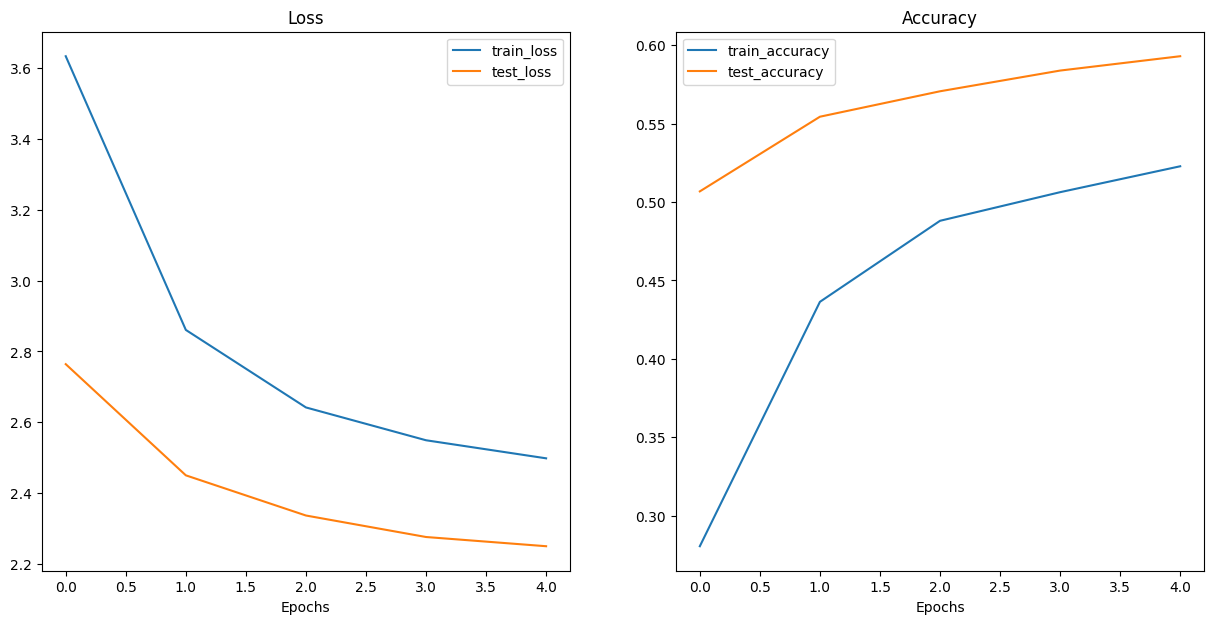

In [74]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_food101_results)

In [75]:
from going_modular.going_modular import utils

# Create a model path
effnetb2_food101_model_path = "09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"

# Save FoodVision Big model
utils.save_model(model=effnetb2_food101,
                 target_dir="models",
                 model_name=effnetb2_food101_model_path)

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth


In [76]:
loaded_effnetb2_food101, effnetb2_transforms =create_effnetb2_model(num_classes=101)

#load the saved models state dict
loaded_effnetb2_food101.load_state_dict(torch.load('models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth'))

<All keys matched successfully>

In [77]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_food101_model_size = Path("models", effnetb2_food101_model_path).stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained EffNetB2 feature extractor Food101 model size: {pretrained_effnetb2_food101_model_size} MB")

Pretrained EffNetB2 feature extractor Food101 model size: 30 MB


# 100% of the data

In [78]:
BATCH_SIZE = 32
NUM_WORKERS = 2

train_101_dataloader_big = torch.utils.data.DataLoader(dataset=train_data,
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=True,
                                                  num_workers=NUM_WORKERS)

test_101_dataloader_big = torch.utils.data.DataLoader(dataset=test_data,
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=False,
                                                  num_workers=NUM_WORKERS)

In [79]:
len(train_101_dataloader_big)

2368

In [80]:
from going_modular.going_modular import engine

loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(),
                             lr=0.001)

effnetb2_food101_big_results = engine.train(model=effnetb2_food101,
                                        train_dataloader=train_101_dataloader,
                                        test_dataloader=test_101_dataloader_big,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=5,
                                        device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.4647 | train_acc: 0.5330 | test_loss: 2.2426 | test_acc: 0.5868
Epoch: 2 | train_loss: 2.4049 | train_acc: 0.5452 | test_loss: 2.2340 | test_acc: 0.5864
Epoch: 3 | train_loss: 2.3890 | train_acc: 0.5522 | test_loss: 2.2237 | test_acc: 0.5915
Epoch: 4 | train_loss: 2.3626 | train_acc: 0.5605 | test_loss: 2.2142 | test_acc: 0.5927
Epoch: 5 | train_loss: 2.3546 | train_acc: 0.5603 | test_loss: 2.2124 | test_acc: 0.5930


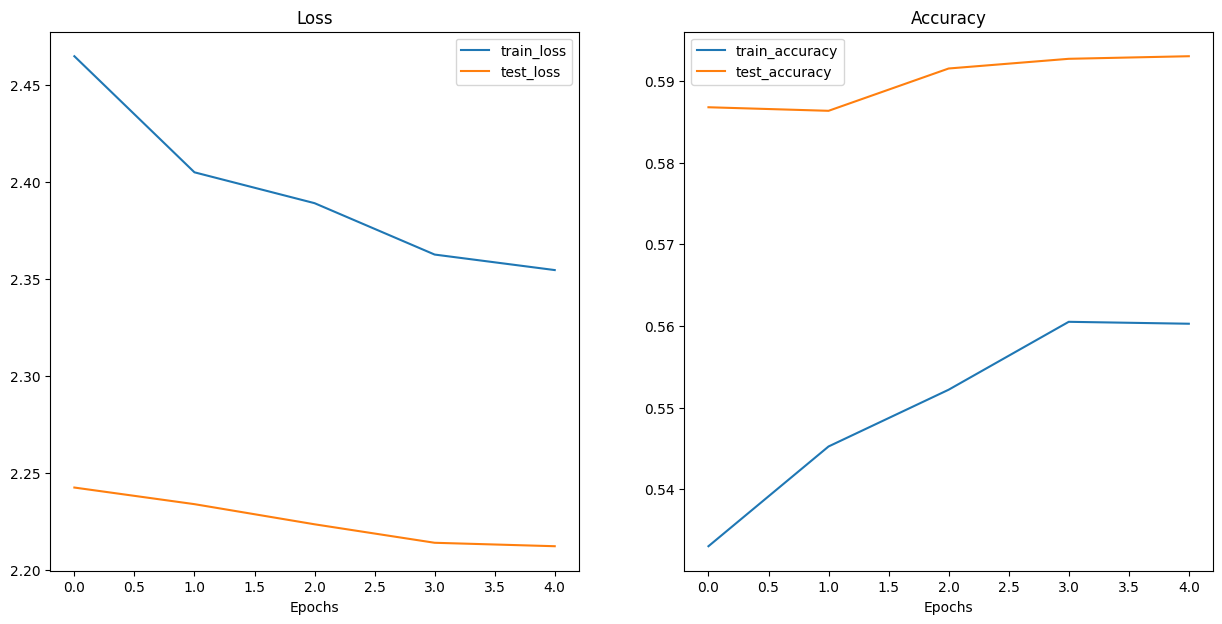

In [81]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_food101_big_results)

In [82]:
from going_modular.going_modular import utils

# Create a model path
effnetb2_food101_big_model_path = "09_pretrained_effnetb2_feature_extractor_food101_big.pth"

# Save FoodVision Big model
utils.save_model(model=effnetb2_food101,
                 target_dir="models",
                 model_name=effnetb2_food101_big_model_path)

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_food101_big.pth


In [83]:
loaded_effnetb2_food101_big, effnetb2_transforms =create_effnetb2_model(num_classes=101)

#load the saved models state dict
loaded_effnetb2_food101_big.load_state_dict(torch.load('models/09_pretrained_effnetb2_feature_extractor_food101_big.pth'))

<All keys matched successfully>

In [84]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_food101_big_model_size = Path("models", effnetb2_food101_big_model_path).stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained EffNetB2 feature extractor Food101_big model size: {pretrained_effnetb2_food101_big_model_size} MB")

Pretrained EffNetB2 feature extractor Food101_big model size: 30 MB


#Creating an app

In [85]:
from pathlib import Path

foodvision_big_demo_path = Path('demos/foodvision_big/')

#big demo path
foodvision_big_demo_path.mkdir(parents=True,
                               exist_ok=True)

#example direc
(foodvision_big_demo_path / 'examples').mkdir(parents=True,
                                              exist_ok=True)

In [86]:
# Download and move an example image
!wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
!mv 04-pizza-dad.jpeg demos/foodvision_big/examples/04-pizza-dad.jpg

# Move trained model to FoodVision Big demo folder (will error if model is already moved)
!mv models/09_pretrained_effnetb2_feature_extractor_food101_big.pth demos/foodvision_big

--2024-04-15 07:51:30--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘04-pizza-dad.jpeg’

04-pizza-dad.jpeg   100%[===================>]   2.74M  --.-KB/s    in 0.06s   

2024-04-15 07:51:30 (43.3 MB/s) - ‘04-pizza-dad.jpeg’ saved [2874848/2874848]



In [87]:
food101_class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [88]:
#food101 class names path
foodvision_big_class_names_path = foodvision_big_demo_path / 'class_names.txt'
foodvision_big_class_names_path

PosixPath('demos/foodvision_big/class_names.txt')

In [89]:
with open(foodvision_big_class_names_path, 'w') as f:
  print(f'[INFO] Saving Food101 class names to {foodvision_big_class_names_path}')
  f.write('\n'.join(food101_class_names))

[INFO] Saving Food101 class names to demos/foodvision_big/class_names.txt


In [90]:
%%writefile demos/foodvision_big/model.py
import torch
import torchvision
from torch import nn

def create_effnetb2_model(num_classes:int=3,
                          seed:int=33):

  effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

  transforms = effnetb2_weights.transforms()

  model = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)

  model.classifier = nn.Sequential(nn.Dropout(p=0.3, inplace=True),
                                    nn.Linear(in_features=1408,
                                              out_features=num_classes))

  return model, transforms

Writing demos/foodvision_big/model.py


In [92]:
%%writefile demos/foodvision_big/app.py
# imports and class_names
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timer import default_timer as timer
from typing import Tuple, Dict

#setup class names
with open('class_names.txt', 'r') as f:
  class_names = [food_name.strip() for food_name in f.readlines()]

#model and transforms
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=101)

#laod weights
effnetb2.load_state_dict(
    torch.load(f='09_pretrained_effnetb2_feature_extractor_food101_big.pth',
               map_location=torch.device('cpu'))
)

# pred fn
def predict(img) -> Tuple[Dict, float]:

  start_time = timer()

  #transform image
  img = effnetb2_transforms(img).unsqueeze(0)

  #put model in eval mode and make prediction
  effnetb2.eval()
  with torch.inference_mode():
    pred_probs = torch.softmax(effnetb2(img), dim=1)

  #create a pred label and pred probability dict
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  #calc pred time
  end_time = timer()
  pred_time = round(end_time - start_time, 4)
  return pred_labels_and_probs, pred_time

#Gradio app
title = 'FoodVision Big-V 🍴'
description = "An EfficientNetB2 feature extractor computer vision model to classify images 101 classes of food from the Food101 dataset."

#create example list
example_list = [['examples/' + example] for example in os.listdir('examples')]

demo = gr.Interface(inputs=gr.Image(type='pil'),
                    outputs=[gr.Label(num_top_classes=5, label='Predictions'),
                             gr.Number(label='Prediction time (s)')],
                    examples=example_list,
                    fn=predict,
                    title=title,
                    description=description)

demo.launch(debug=False,
            share=True)

Writing demos/foodvision_big/app.py


# requirements.txt for foodvision big

In [93]:
%%writefile demos/foodvision_big/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Writing demos/foodvision_big/requirements.txt


#Zip and download

In [94]:
!cd demos/foodvision_big && zip -r ../foodvision_big.zip * -x '*.pyc' '*.ipynb' '*.pycache*' '*.ipynb_checkpoints*'

  adding: 09_pretrained_effnetb2_feature_extractor_food101_big.pth (deflated 8%)
  adding: app.py (deflated 53%)
  adding: class_names.txt (deflated 48%)
  adding: examples/ (stored 0%)
  adding: examples/04-pizza-dad.jpg (deflated 0%)
  adding: model.py (deflated 53%)
  adding: requirements.txt (deflated 4%)


In [95]:
#downloading
try:
    from google.colab import files
    files.download("demos/foodvision_big.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download(), please manually download.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [96]:
timer.__version__

AttributeError: 'builtin_function_or_method' object has no attribute '__version__'